In [1]:
#coding:utf-8
import time
import datetime
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


import lightgbm as lgb
from dateutil.parser import parse
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

/home/betten/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [136]:
data_path = './data/'
train = pd.read_csv(data_path+'d_train_20180102.csv',encoding='gb2312')
test = pd.read_csv(data_path+'d_test_A_20180102.csv',encoding='gb2312')

In [137]:
print('train shape', train.shape)
print('test shape', test.shape)

train shape (5642, 42)
test shape (1000, 41)


In [138]:
#check the decoration
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

In [139]:
train_id = train.id.values.copy()
test_id = test.id.values.copy()
data = pd.concat([train,test])

In [140]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
min_miss_feat = missing_data[missing_data['Percent']<=0.2][missing_data['Percent']>0].index.tolist()
max_miss_feat = missing_data[missing_data['Percent']>=0.6].index.tolist()
generic_miss_feat = missing_data[missing_data['Percent']<0.6][missing_data['Percent']>0.2].index.tolist()
missing_data.head(5)

/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,Total,Percent
乙肝e抗原,5110,0.769347
乙肝表面抗原,5110,0.769347
乙肝表面抗体,5110,0.769347
乙肝核心抗体,5110,0.769347
乙肝e抗体,5110,0.769347


In [141]:
#描述性转数值型
data['性别'] = data['性别'].map({'男':1, '女':0})
data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2017-10-09')).dt.days

In [142]:
#删除max_miss_feat列
data = data.drop(max_miss_feat, axis=1)

In [143]:
#min_miss_feat列使用均值填充
for feat in min_miss_feat:
    data[feat].fillna(data[feat].median(axis=0),inplace=True)

In [144]:
#对性别进行填充
data['性别'].fillna(1.0, inplace=True)

In [145]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).head()

,Total,Percent
肌酐,1572,0.236676
尿素,1572,0.236676
尿酸,1572,0.236676
*r-谷氨酰基转换酶,1406,0.211683
白蛋白,1406,0.211683


In [146]:
#对generic_miss_feat使用众数和中位数的均值填充,后期考虑特征相似度加权来填充
for feat in generic_miss_feat:
    fill_val = round((data[feat].median()+(data[feat].mode().values).mean())/2, 4)
    data[feat].fillna(fill_val, inplace=True)

In [147]:
#Check remaining missing values if any 
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [148]:
train = data[data.id.isin(train_id)]
test = data[data.id.isin(test_id)]
test = test.drop(['血糖'], axis=1)

In [149]:
for feat in max_miss_feat:
    train_cols.remove(feat)
    test_cols.remove(feat)

In [150]:
train = train.ix[:,train_cols]
test = test.ix[:,test_cols]

/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [154]:
data = data.ix[:,train_cols]
data.head()

/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,id,性别,年龄,体检日期,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,...,血小板计数,血小板平均体积,血小板体积分布宽度,血小板比积,中性粒细胞%,淋巴细胞%,单核细胞%,嗜酸细胞%,嗜碱细胞%,血糖
0,1,1.0,41,62,24.96,23.10,99.59,20.23,76.88,49.60,...,166.0,9.9,17.4,0.164,54.1,34.2,6.5,4.7,0.6,6.06
1,2,1.0,41,10,24.57,36.25,67.21,79.00,79.43,47.76,...,277.0,9.2,10.3,0.260,52.0,36.7,5.8,4.7,0.8,5.39
2,3,1.0,46,17,20.82,15.23,63.69,38.17,86.23,48.00,...,241.0,8.3,16.6,0.199,48.1,40.3,7.7,3.2,0.8,5.59
3,4,0.0,22,16,14.99,10.59,74.08,20.22,70.98,44.02,...,252.0,10.3,10.8,0.260,41.7,46.5,6.7,4.6,0.5,4.30
4,5,0.0,48,17,20.07,14.78,75.79,22.72,78.05,41.83,...,316.0,11.1,14.0,0.350,56.6,33.1,9.1,0.6,0.6,5.42


In [165]:
data.columns

Index(['id', '性别', '年龄', '体检日期', '*天门冬氨酸氨基转换酶', '*丙氨酸氨基转换酶', '*碱性磷酸酶',
       '*r-谷氨酰基转换酶', '*总蛋白', '白蛋白', '*球蛋白', '白球比例', '甘油三酯', '总胆固醇',
       '高密度脂蛋白胆固醇', '低密度脂蛋白胆固醇', '尿素', '肌酐', '尿酸', '白细胞计数', '红细胞计数', '血红蛋白',
       '红细胞压积', '红细胞平均体积', '红细胞平均血红蛋白量', '红细胞平均血红蛋白浓度', '红细胞体积分布宽度', '血小板计数',
       '血小板平均体积', '血小板体积分布宽度', '血小板比积', '中性粒细胞%', '淋巴细胞%', '单核细胞%', '嗜酸细胞%',
       '嗜碱细胞%', '血糖'],
      dtype='object')

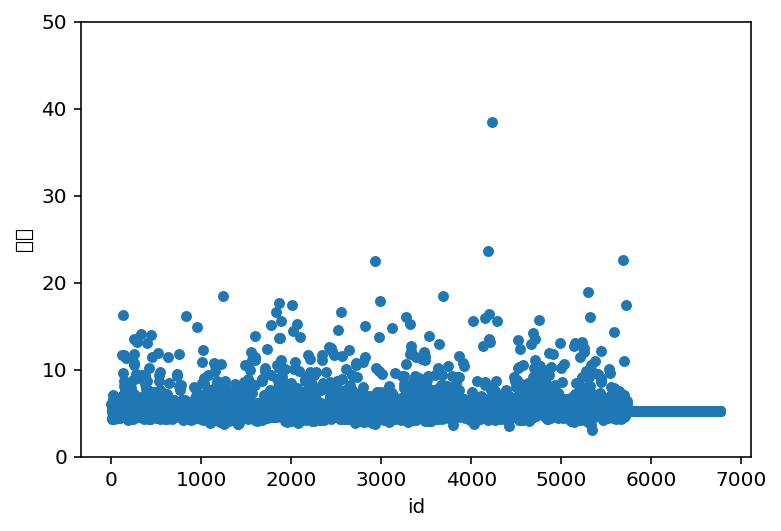

In [270]:
#scatter plot
temp = pd.concat([data['id'], data['血糖']], axis=1)
temp.plot.scatter(x='id', y='血糖', ylim=(0,50));

In [263]:
data['嗜酸细胞%'][data['嗜酸细胞%']>20] = data['嗜酸细胞%'].mean()

/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [272]:
train = data[data.id.isin(train_id)]
test = data[data.id.isin(test_id)]
test = test.drop(['血糖'], axis=1)

    
#数据集特征重新排列
train = train.ix[:,train_cols]
test = test.ix[:,test_cols]

/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/home/betten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [277]:
train.head()

,id,性别,年龄,体检日期,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,...,血小板计数,血小板平均体积,血小板体积分布宽度,血小板比积,中性粒细胞%,淋巴细胞%,单核细胞%,嗜酸细胞%,嗜碱细胞%,血糖
0,1,1.0,41,62,24.96,23.10,99.59,20.23,76.88,49.60,...,166.0,9.9,17.4,0.164,54.1,34.2,6.5,4.7,0.6,6.06
1,2,1.0,41,10,24.57,36.25,67.21,79.00,79.43,47.76,...,277.0,9.2,10.3,0.260,52.0,36.7,5.8,4.7,0.8,5.39
2,3,1.0,46,17,20.82,15.23,63.69,38.17,86.23,48.00,...,241.0,8.3,16.6,0.199,48.1,40.3,7.7,3.2,0.8,5.59
3,4,0.0,22,16,14.99,10.59,74.08,20.22,70.98,44.02,...,252.0,10.3,10.8,0.260,41.7,46.5,6.7,4.6,0.5,4.30
4,5,0.0,48,17,20.07,14.78,75.79,22.72,78.05,41.83,...,316.0,11.1,14.0,0.350,56.6,33.1,9.1,0.6,0.6,5.42


In [278]:
test.head()

,id,性别,年龄,体检日期,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,...,红细胞体积分布宽度,血小板计数,血小板平均体积,血小板体积分布宽度,血小板比积,中性粒细胞%,淋巴细胞%,单核细胞%,嗜酸细胞%,嗜碱细胞%
0,5733,1.0,54,1,23.8500,26.6900,116.0800,34.3600,82.75,46.030,...,12.3,241.0,10.8,12.8,0.26,58.4,33.2,7.5,0.6,0.3
1,5734,1.0,50,1,29.7500,34.9800,90.0700,111.4300,71.90,44.090,...,12.0,242.0,11.5,14.6,0.28,59.3,29.3,7.7,3.2,0.5
2,5735,1.0,27,1,21.7925,18.6825,82.4017,22.1075,76.20,45.395,...,12.1,398.0,8.9,9.9,0.35,50.2,40.1,7.9,1.2,0.6
3,5736,0.0,53,1,17.9800,16.6300,95.9500,23.4100,78.16,45.440,...,12.6,247.0,11.6,13.9,0.29,53.7,38.0,7.2,0.7,0.4
4,5739,0.0,43,1,19.1200,19.8000,76.9700,15.7000,80.76,46.900,...,12.2,335.0,10.4,11.9,0.35,52.0,39.4,8.0,0.3,0.3


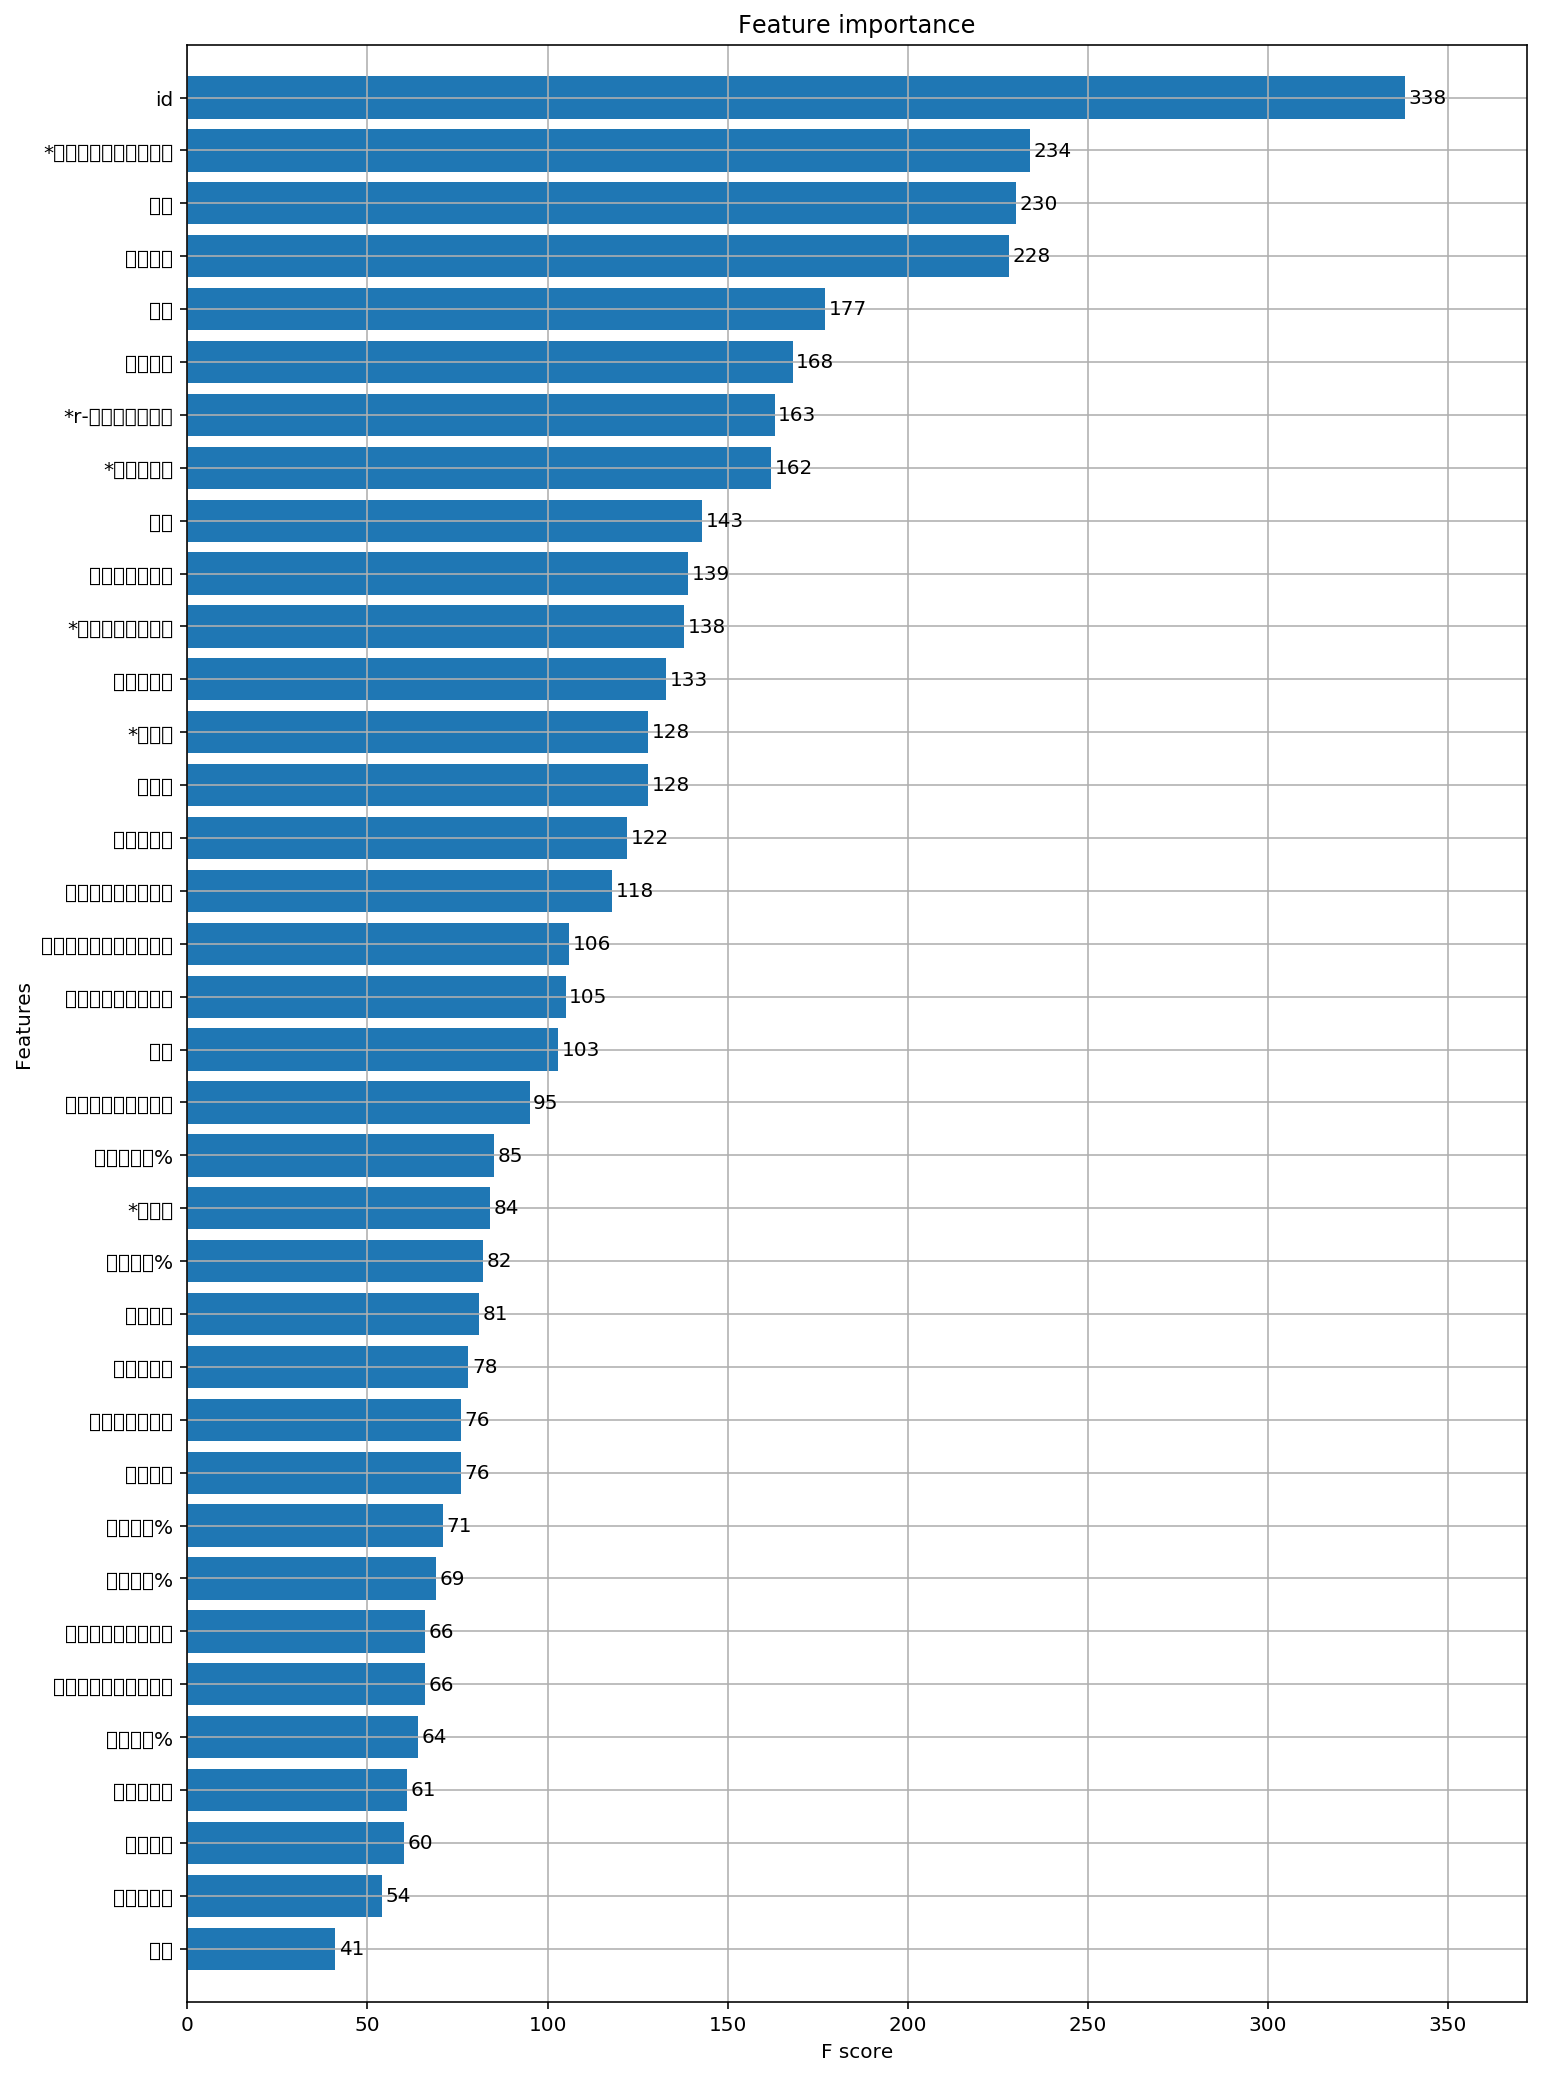

In [280]:
import xgboost as xgb
y_train = train['血糖']
X_train = train.drop(['血糖'], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [289]:
cols = data.columns.tolist()
cols.remove('id')
cols.remove('血糖')
cols.remove('性别')
cols.remove('年龄')
cols.remove('体检日期')

/home/betten/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


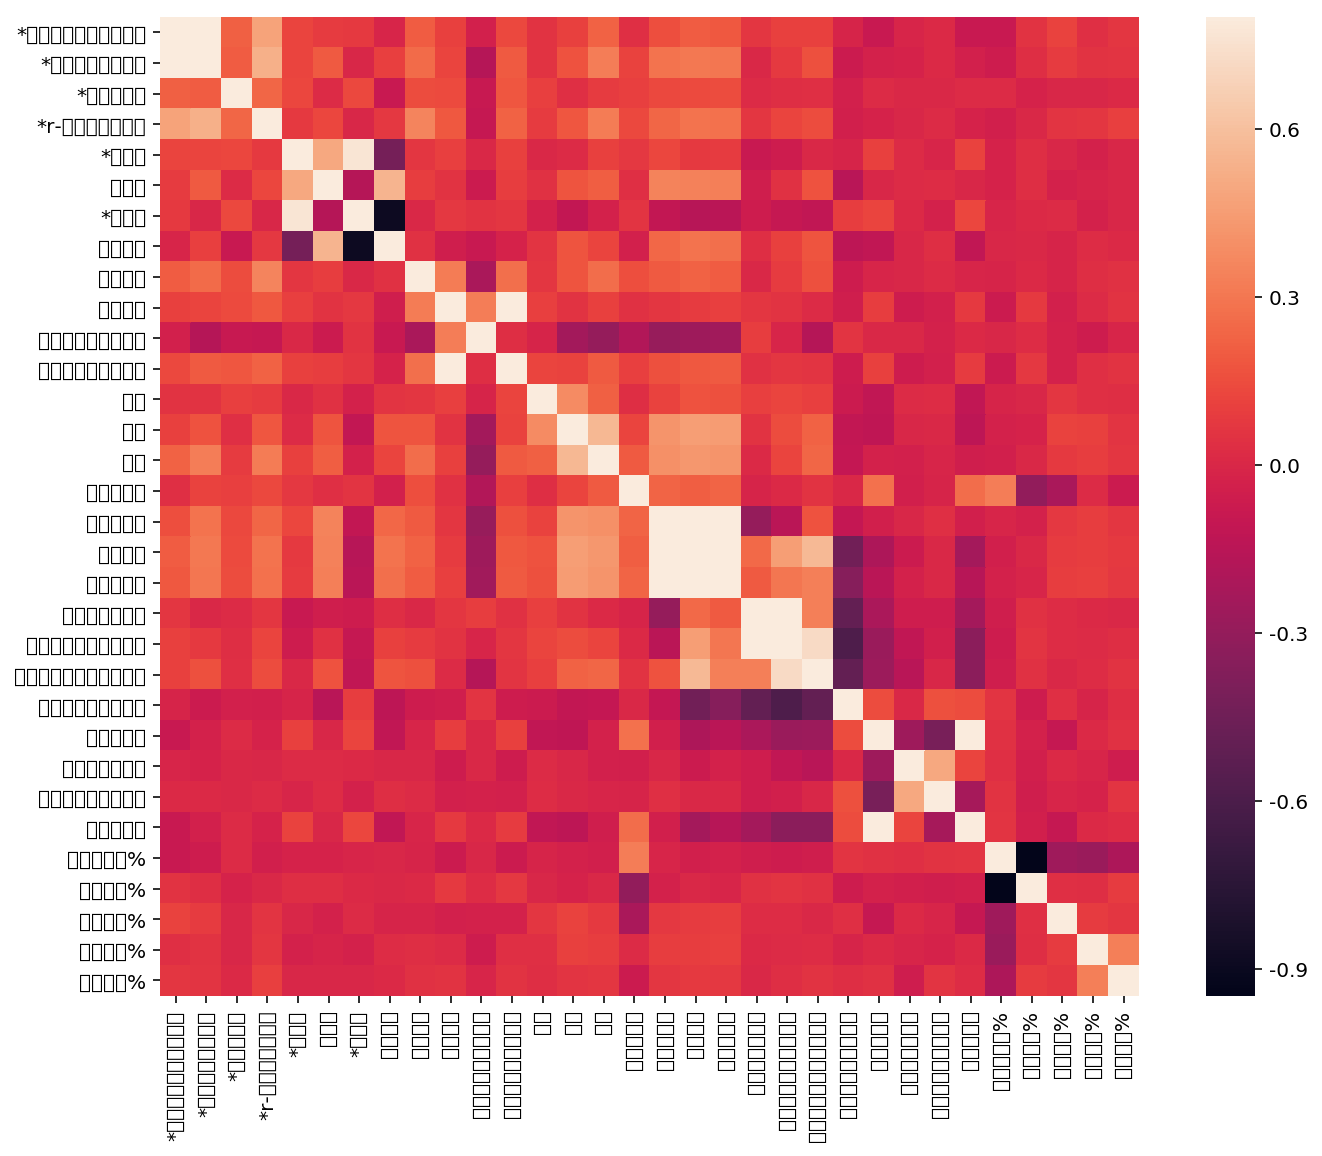

In [292]:
#correlation matrix
corrmat = data[cols].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [293]:
from sklearn.preprocessing import PolynomialFeatures
tran_data = PolynomialFeatures().fit_transform(data[cols])

In [295]:
tran_data.shape

(6642, 561)

In [297]:
from numpy import log1p
from sklearn.preprocessing import FunctionTransformer
#自定义转换函数为对数函数的数据变换
#第一个参数是单变元函数
log_data = FunctionTransformer(log1p).fit_transform(data[cols])

In [298]:
log_data.shape

(6642, 32)

In [318]:
tran = pd.DataFrame(log_data)
new_data = pd.concat([data, tran], axis=1, join_axes=[data.index])

In [379]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
血糖,6.062385
甘油三酯,5.960447
*r-谷氨酰基转换酶,4.717911
*天门冬氨酸氨基转换酶,4.208533
*丙氨酸氨基转换酶,3.493360


In [372]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness.dropna(axis=0)
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 17 skewed numerical features to Box Cox transform


In [373]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    new_data['skew'+feat] = boxcox1p(data[feat], lam)
new_data = new_data.drop(['skew血糖'], axis=1)

In [375]:
new_data.head()

,id,性别,年龄,体检日期,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,...,skew嗜碱细胞%,skew*碱性磷酸酶,skew尿素,skew体检日期,skew高密度脂蛋白胆固醇,skew白细胞计数,skew肌酐,skew单核细胞%,skew红细胞平均体积,skew红细胞平均血红蛋白量
0,1,1.0,41,62,24.96,23.10,99.59,20.23,76.88,49.60,...,0.486968,6.646825,2.234609,5.744420,0.921223,2.128056,6.154614,2.352532,6.488947,4.592030
1,2,1.0,41,10,24.57,36.25,67.21,79.00,79.43,47.76,...,0.614477,5.893227,2.111319,2.885846,0.691038,2.547608,6.385118,2.220945,6.393545,4.486611
2,3,1.0,46,17,20.82,15.23,63.69,38.17,86.23,48.00,...,0.614477,5.793800,2.004651,3.618223,1.045019,1.965840,6.177599,2.555578,6.488947,4.560990
3,4,0.0,22,16,14.99,10.59,74.08,20.22,70.98,44.02,...,0.418049,6.075327,1.877781,3.530419,0.949732,2.800340,5.728405,2.388206,6.531046,4.592030
4,5,0.0,48,17,20.07,14.78,75.79,22.72,78.05,41.83,...,0.486968,6.118443,1.981186,3.618223,0.872314,2.070830,6.177356,2.764316,5.934004,3.903378


In [381]:
new_data = new_data.drop(['skew体检日期'], axis=1)
new_data_na = (new_data.isnull().sum() / len(new_data)) * 100
new_data_na = new_data_na.drop(new_data_na[new_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :new_data_na})
missing_data.head(20)

,Missing Ratio


In [382]:
new_data_na = ((new_data==0).sum() / len(new_data)) * 100
new_data_na = new_data_na.drop(new_data_na[new_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :new_data_na})
missing_data.head(20)

,Missing Ratio
性别,49.879554
skew嗜酸细胞%,0.195724
30,0.195724
嗜酸细胞%,0.195724
skew嗜碱细胞%,0.150557
31,0.150557
嗜碱细胞%,0.150557


In [383]:
new_data.columns

Index([             'id',              '性别',              '年龄',
                  '体检日期',     '*天门冬氨酸氨基转换酶',       '*丙氨酸氨基转换酶',
                '*碱性磷酸酶',      '*r-谷氨酰基转换酶',            '*总蛋白',
                   '白蛋白',            '*球蛋白',            '白球比例',
                  '甘油三酯',            '总胆固醇',       '高密度脂蛋白胆固醇',
             '低密度脂蛋白胆固醇',              '尿素',              '肌酐',
                    '尿酸',           '白细胞计数',           '红细胞计数',
                  '血红蛋白',           '红细胞压积',         '红细胞平均体积',
            '红细胞平均血红蛋白量',     '红细胞平均血红蛋白浓度',       '红细胞体积分布宽度',
                 '血小板计数',         '血小板平均体积',       '血小板体积分布宽度',
                 '血小板比积',          '中性粒细胞%',           '淋巴细胞%',
                 '单核细胞%',           '嗜酸细胞%',           '嗜碱细胞%',
                    '血糖',                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,               

# 特征选择

In [384]:
train = new_data[new_data.id.isin(train_id)]

In [388]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [397]:
def mse_cv(model):
    mse= -cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 5)
    return(0.5*mse)

In [398]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train, y_train)

In [405]:
mse_cv(model_lasso)

array([  3.14998709e-08,   5.42637832e-08,   5.29536166e-08,
         8.72992675e-08,   5.46178041e-08])

In [406]:
coef = pd.Series(model_lasso.coef_, index = train.columns)

In [407]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 77 variables


In [408]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [425]:
#saleprice correlation matrix
k = 50 #number of variables for heatmap
corrmat = train.corr()
corr_cols = corrmat.nlargest(k, '血糖')['血糖'].index
corr_cols

Index([             '血糖',              '年龄',        'skew甘油三酯',
                       8,            '甘油三酯',                 3,
        'skew*r-谷氨酰基转换酶',      'skew*碱性磷酸酶',          '*碱性磷酸酶',
                       2,       '低密度脂蛋白胆固醇',            '血红蛋白',
                      17,                11,              '性别',
                    '尿素',     '红细胞平均血红蛋白浓度',          'skew尿素',
                      12,                21,                 1,
         'skew*丙氨酸氨基转换酶',            '总胆固醇',      '*r-谷氨酰基转换酶',
                      16,           '红细胞计数',                18,
                 '红细胞压积',                 9,       '*丙氨酸氨基转换酶',
           '*天门冬氨酸氨基转换酶', 'skew*天门冬氨酸氨基转换酶',                 0,
                    '肌酐',       'skew白细胞计数',                15,
                'skew肌酐',                13,           '白细胞计数',
            '红细胞平均血红蛋白量',  'skew红细胞平均血红蛋白量',                20,
                  '*球蛋白',                 6,          '中性粒细胞%',
                      27,              '

In [426]:
corr_cols.drop(['血糖'])

Index([             '年龄',        'skew甘油三酯',                 8,
                  '甘油三酯',                 3,  'skew*r-谷氨酰基转换酶',
            'skew*碱性磷酸酶',          '*碱性磷酸酶',                 2,
             '低密度脂蛋白胆固醇',            '血红蛋白',                17,
                      11,              '性别',              '尿素',
           '红细胞平均血红蛋白浓度',          'skew尿素',                12,
                      21,                 1,   'skew*丙氨酸氨基转换酶',
                  '总胆固醇',      '*r-谷氨酰基转换酶',                16,
                 '红细胞计数',                18,           '红细胞压积',
                       9,       '*丙氨酸氨基转换酶',     '*天门冬氨酸氨基转换酶',
       'skew*天门冬氨酸氨基转换酶',                 0,              '肌酐',
             'skew白细胞计数',                15,          'skew肌酐',
                      13,           '白细胞计数',      '红细胞平均血红蛋白量',
        'skew红细胞平均血红蛋白量',                20,            '*球蛋白',
                       6,          '中性粒细胞%',                27,
                    'id',            '*总

In [427]:
from sklearn.preprocessing import PolynomialFeatures
tran_data = PolynomialFeatures().fit_transform(data[cols])

In [430]:
tran_data = pd.DataFrame(tran_data, columns=[x+80 for x in range(561)])

In [432]:
tran_data = tran_data.drop([80], axis=1)